# Assignment - Artificial Intelligence 1:

## Assignment Background:

Timely submission will result in your assignment being returned within 14 days of the submission deadline. Marked Jupyter Notebook manuscripts will be returned with comments from your marker. If you receive a pass or distinction, your marker will attach the model solutions for this assignment *via* the open pull request on your lesson's GitHub repository.

This assignments aim is to combine everything you have learned in this lesson. However, do not worry about creating the perfect neural net. Instead, the idea is to have you actively using and implementing a neural net for a new task.

In your `data` folder there is a tabular dataset with measurements from differing forests, the aim is to predict the forest cover type from just these cartographic variables. The dataset is made publicly available from [UC Irvine](https://archive.ics.uci.edu/dataset/31/covertype).

The dataset will be loaded in for you via pre-filled code cells in the assignment notebook.

*Note: The dataset when loaded from the given file does not come with any column headings, which can be a bit disconcerting. However, it is a good example of how neural networks will work even without an understanding of the features*

## Assignment Questions:

## Question 1

**Part A**

Explore the dataset we have given to you, `X` = the data, `y` = the target variable:
- View the X and y data and check for missing values
- The target (y) categories start from 1 through to 7. Our machine learning models expect the categories to start from 0 onwards. Please alter all the data in `y` to be one less. I.e. 1 -> 0, 2 -> 1, 3 -> 2, etc.

In [87]:
import pandas as pd
import torch

file_path = './data/covtype.data.gz'

# Load the compressed data 
df = pd.read_csv(file_path, header=None)
print(f"Dataset loaded: {df.shape[0]} samples with {df.shape[1]} features.")

X = df.iloc[:, :-1]
y = df.iloc[:, -1] # The target is the last column

Dataset loaded: 581012 samples with 55 features.


In [88]:
# The labels your model actually predicts

model_prediction_mapping = {
    0: "Spruce/Fir",
    1: "Lodgepole Pine",
    2: "Ponderosa Pine",
    3: "Cottonwood/Willow",
    4: "Aspen",
    5: "Douglas-fir",
    6: "Krummholz"
}

In [89]:
# Check the data here

print(X.shape)

X.head(3)

(581012, 54)


0    1   2    3   4     5    6    7    8     9   ...  44  45  46  47  48  \
0  2596   51   3  258   0   510  221  232  148  6279  ...   0   0   0   0   0   
1  2590   56   2  212  -6   390  220  235  151  6225  ...   0   0   0   0   0   
2  2804  139   9  268  65  3180  234  238  135  6121  ...   0   0   0   0   0   

   49  50  51  52  53  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  

[3 rows x 54 columns]

In [90]:
y.head(3)

0    5
1    5
2    2
Name: 54, dtype: int64

In [91]:
check = X.isnull().any().any()

if check == True:
    print("There is missing data, please check")
elif check == False:
    print("All data is present")

All data is present


In [92]:
# Convert the target variables

# Check what categories we have
y.value_counts()

54
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

In [93]:
# Using columnar operation we can minus 1 from each row
y = y - 1

y

0         4
1         4
2         1
3         1
4         4
         ..
581007    2
581008    2
581009    2
581010    2
581011    2
Name: 54, Length: 581012, dtype: int64

In [94]:
# Check the distribution again
y.value_counts()

54
1    283301
0    211840
2     35754
6     20510
5     17367
4      9493
3      2747
Name: count, dtype: int64

**Part B**

Split the data into your test, train datasets:
- Use the sklearn function `train_test_split`
- Use an appropriate test size
- Both shuffle and stratify the datasets
- Print the shape of both train and test dataset to confirm

In [95]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.3,
                                                            shuffle=True,
                                                            stratify = y,
                                                            random_state=2026)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (406708, 54)
X_test shape:  (174304, 54)


## Question 2

**Part A**

Create a subclassed `Dataset` class to store the tabular data, to be given to the `DataLoader` class.
- Create a class called `SimpleTabularDataset` that subclasses PyTorch's `Dataset` (see the materials for help).
- Create a dataset for both the train and test data
- Give them as arguments to the `DataLoader` class from PyTorch
    - Use appropriate batch sizes for each

In [96]:
# Create your Dataset class

from torch.utils.data import Dataset, DataLoader
from torch import LongTensor, FloatTensor
import numpy as np

class SimpleTabularDataset(Dataset):
    """Simple dataset for tabular data."""
    
    def __init__(self, X, y):
        """
        X: Your features (pandas DataFrame or numpy array)
        y: Your targets (pandas Series or numpy array)
        """
        super().__init__()
        
        # Pandas has .values, numpy does not
        if hasattr(X, 'values'): # pandas
            X = X.values
            y = y.values
        else: # numpy
            X = np.array(X)
            y = np.array(y)
        
        # Convert to torch tensors
        self.X = FloatTensor(X) # float tensor = float
        self.y = LongTensor(y) # long tensor = integer
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [97]:
# Initialise the class and give to DataLoader

train_dataset = SimpleTabularDataset(X_train, y_train)
test_dataset = SimpleTabularDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

**Part B**

Create an MLP class using the techniques shown in this lesson
- You are free to use how many layers you like
- As well as any activation function
- **Do not** include a softmax layer as we will be using `nn.CrossEntropyLoss()` later
- Use some random data to test the model is functioning properly

It would be good to experiment with different architectures. However, for submission please only give one. You will be marked solely on a functioning model, not how it performs.

In [98]:
# Create your MLP class

import torch.nn as nn

class forest_MLP(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.network(x)

In [99]:
# Create an instance of the MLP class & test with random numbers

input_dims = X.shape[1]
output_dims = len(model_prediction_mapping)
model = forest_MLP(input_size=input_dims, output_size=output_dims)

random_input = torch.randn(1, input_dims, device='cpu')

# Call the model
prediction = model(random_input)
prediction

tensor([[ 0.0267,  0.0727, -0.0078, -0.0952,  0.0119,  0.1373,  0.1067]],
       grad_fn=<AddmmBackward0>)

## Question 3

**Part A**

**Training and Testing Functions**

The `train()` and `test()` functions given in the lesson materials are provided below with some modifications (loss now utilises `nn.CrossEntropyLoss()`).

Review these functions and modify them as so:

`train()`
- The training loss is captured per batch to give the loss for the epoch
- Return the loss from the `train` function (remember to get the average loss, not total!)

`test()`
- The test loss is captured for `nn.CrossEntropyLoss()` not null loss


To obtain the average loss from the batch, please use the following code:
```
batch_loss = loss.item()*data.size(0)
```

In [113]:
import torch.nn.functional as F

def train(model, device, train_loader, optimiser, epoch):
    """
    Train a neural network model for one epoch.
    
    :param model: The neural network model to train. Must have a forward() method
                  and be compatible with PyTorch's training paradigm.
    :type model: torch.nn.Module
    :param device: The device (CPU or GPU) on which to perform training computations.
                   Typically created using torch.device("cpu") or torch.device("cuda").
    :type device: torch.device
    :param train_loader: DataLoader containing the training dataset. Yields batches
                         of (data, target) tuples during iteration.
    :type train_loader: torch.utils.data.DataLoader
    :param optimiser: The optimization algorithm used to update model parameters.
                      Common choices include SGD, Adam, etc.
    :type optimiser: torch.optim.Optimizer
    :param epoch: Current epoch number (used for progress reporting).
    :type epoch: int
    
    :returns: the training loss
    """

    model.train() # set the model to training mode

    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):

        # Load the data in and its target variables
        data, target = data.to(device), target.to(device) # send the data to the device

        # Complete a forward pass and calculate the loss
        optimiser.zero_grad() # zero the gradients
        output = model(data) # forward pass
        loss = F.cross_entropy(output, target) # updated to have CrossEntropyLoss

        loss.backward() # backward pass
        optimiser.step() # update the weights

        batch_loss = loss.item()*data.size(0)
        train_loss += batch_loss

    train_loss /= len(train_loader.dataset)

    return train_loss

In [114]:
def test(model, device, test_loader):
    """
    Evaluate a trained neural network model on the test dataset.
    
    :param model: The trained neural network model to evaluate. Must have a forward()
                  method and be compatible with PyTorch's evaluation paradigm.
    :type model: torch.nn.Module
    :param device: The device (CPU or GPU) on which to perform evaluation computations.
                   Typically created using torch.device("cpu") or torch.device("cuda").
    :type device: torch.device
    :param test_loader: DataLoader containing the test dataset. Yields batches of
                        (data, target) tuples during iteration.
    :type test_loader: torch.utils.data.DataLoader
    
    :returns: the testing loss
    """
    model.eval() # set the model to evaluation mode

    # Set variables to collect cumulative loss and correct predictions
    test_loss = 0
    correct = 0

    with torch.no_grad(): # don't calculate the gradients

        for data, target in test_loader:

            data, target = data.to(device), target.to(device) # send the data to the device

            # Complete a forward pass and calculate the loss
            output = model(data) # forward pass
            loss = F.cross_entropy(output, target) # updated to have CrossEntropyLoss

            test_loss += loss.item()*data.size(0)
            
            # Get the top prediction and check if correct
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item() # Check if the prediction is correct

    # Calculate the average loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('--------Evaluation--------\n')
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')
    print('--------Next Epoch--------\n')

    return test_loss

**Part B**

**Initialise and Train the model**

- Set the device for the workspace using the code given below
- Initialise the model and move to the device
- Setup the optimiser for the training
    - Use the [Adam optimiser](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html) instead of SGD
    - Use a learning rate of `0.001`
- Write and call the training loop
    - Call the training for 10 epochs
    - Append the losses for train and test to their own lists outside the loop

In [115]:
# Check if GPU is available
if torch.cuda.is_available():
    # if there are multiple GPUs, choose the first one
    device = torch.device("cuda") # Defines the device you want to have data moved to
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f"Using: {device} (Cuda)")

# Apple devices also have accelerated hardware
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using: {device} (Apple Silicon)")

else:
    print("No GPU detected! Falling back to CPU")
    # If the GPU is not available, use the CPU
    device = torch.device("cpu")

Using: mps (Apple Silicon)


In [116]:
# Initialise the model here and move to device

model = forest_MLP(input_size=input_dims, output_size=output_dims)
model.to(device)

forest_MLP(
  (network): Sequential(
    (0): Linear(in_features=54, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [117]:
# Create the Adam optimiser class

import torch.optim as optim

optimiser = optim.Adam(model.parameters(), lr=0.001)

In [118]:
# Train the model for 10 epochs

train_losses, test_losses = [], []

for epoch in range(10):

    train_loss = train(model, device, train_loader, optimiser, epoch)
    test_loss = test(model, device, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

--------Evaluation--------

Test set: Average loss: 0.8644, Accuracy: 107878/174304 (62%)
--------Next Epoch--------

--------Evaluation--------

Test set: Average loss: 0.7172, Accuracy: 122313/174304 (70%)
--------Next Epoch--------

--------Evaluation--------

Test set: Average loss: 0.6127, Accuracy: 128292/174304 (74%)
--------Next Epoch--------

--------Evaluation--------

Test set: Average loss: 0.6516, Accuracy: 123553/174304 (71%)
--------Next Epoch--------

--------Evaluation--------

Test set: Average loss: 0.6035, Accuracy: 129547/174304 (74%)
--------Next Epoch--------

--------Evaluation--------

Test set: Average loss: 0.6251, Accuracy: 127195/174304 (73%)
--------Next Epoch--------

--------Evaluation--------

Test set: Average loss: 0.5988, Accuracy: 128786/174304 (74%)
--------Next Epoch--------

--------Evaluation--------

Test set: Average loss: 0.5754, Accuracy: 130832/174304 (75%)
--------Next Epoch--------

--------Evaluation--------

Test set: Average loss: 0.57

## Question 4

Plot the losses for both the training and test data over the epochs:
- Use matplotlib for your plot
- The x-axis will be time (epochs)
- The y-axis the loss

Do you notice anything from the plot?

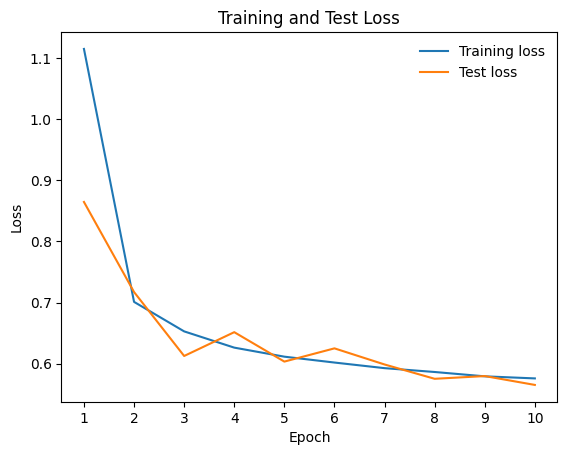

In [120]:
import matplotlib.pyplot as plt

x_epochs = range(1, len(train_losses) + 1)

# plot the training and validation loss
plt.plot(x_epochs, train_losses, label='Training loss')
plt.plot(x_epochs, test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_epochs) 
plt.legend(frameon=False)
plt.title('Training and Test Loss')
plt.show()